In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import models, layers
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications import VGG16, ResNet50, InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score 

Using TensorFlow backend.


## VGG16 and Transfer learning

VGG16 was the top performing model in 2012 imagenet classification competition, it's often used a lot in the machine learning community for it's simple architecture. However, this model has a lot more parameters then the other models we used in this project, 134 million. Compared to the 20 million of the other two models we tried.

In [2]:
#Loops through ImageDataGenerator and grabs true labels and predictions
#and reports metrics with classification_report method
def predict_and_report(gen, model):
    y_true = []
    y_pred = []
    gen.reset()
    for img, label in gen:
        #get true labels for batch and store them
        y_true.extend([int(z[1]) for z in label])
        #Get predictions as probabilities
        batch_pred = model.predict_on_batch(img)
        #turn probabilities to class labels and store
        batch_pred = np.argmax(batch_pred, axis=1)
        y_pred.extend(batch_pred)
        #break loop
        if gen.batch_index == 0:
            break
            
    print(classification_report(y_true, y_pred))

## Parameters

The approach we used for this model was nearly identical to the approach we used in the Inception V3 notebook. Refer to that notebook for a breakdown of some of these parameters. One of the only real differences is that this model was trained for 100 epochs instead of 75, and the image size is smaller. It trains faster because of the image size so we trained for more epochs. training for more epochs is not a problem because we are using a techinque that saves the epoch with the best results.

In [3]:
train_dir = 'C:\\users\\will\\ds\\mammo\\train'
valid_dir = 'C:\\users\\will\\ds\\mammo\\validation'
test_dir = 'C:\\users\\will\\ds\\mammo\\test'

img_width, img_height = 224, 224
batch_size = 64
num_epochs= 100
learning_rate = 1e-5
decay = learning_rate / num_epochs

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb') 

validation_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb')

Found 39011 images belonging to 2 classes.
Found 8436 images belonging to 2 classes.
Found 8438 images belonging to 2 classes.


In [4]:
#Load the VGG model and imagenet weights
vgg16 = VGG16(weights='imagenet', include_top=True, input_shape=(224,224,3))    

# modify output for 2 classes
fc2 = vgg16.get_layer('fc2').output
predictions = Dense(2, activation='softmax', name='predictions')(fc2)
model = Model(inputs=vgg16.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [5]:
adam = keras.optimizers.Adam(lr=learning_rate, decay=decay)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

#Save best weights
filepath="C:\\users\\will\\ds\\mammo-weights-transfer\\weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

result = model.fit_generator(
            train_generator,
            epochs=num_epochs,
            verbose = 1,
            class_weight= {0:.13, 1:.87},
            validation_data = validation_generator,
            callbacks=callbacks_list)

Epoch 1/100
610/610 [==============================] - 374s 613ms/step - loss: 0.0824 - acc: 0.8190 - val_loss: 0.2551 - val_acc: 0.8858

Epoch 00001: val_loss improved from inf to 0.25514, saving model to C:\users\will\ds\mammo-weights-transfer\weights-improvement-01-0.89.hdf5
Epoch 2/100
610/610 [==============================] - 358s 588ms/step - loss: 0.0569 - acc: 0.8913 - val_loss: 0.1619 - val_acc: 0.9365

Epoch 00002: val_loss improved from 0.25514 to 0.16191, saving model to C:\users\will\ds\mammo-weights-transfer\weights-improvement-02-0.94.hdf5
Epoch 3/100
610/610 [==============================] - 358s 586ms/step - loss: 0.0482 - acc: 0.9072 - val_loss: 0.1825 - val_acc: 0.9339

Epoch 00003: val_loss did not improve from 0.16191
Epoch 4/100
610/610 [==============================] - 358s 587ms/step - loss: 0.0414 - acc: 0.9224 - val_loss: 0.1235 - val_acc: 0.9540

Epoch 00004: val_loss improved from 0.16191 to 0.12347, saving model to C:\users\will\ds\mammo-weights-transfer

610/610 [==============================] - 357s 585ms/step - loss: 0.0122 - acc: 0.9778 - val_loss: 0.0878 - val_acc: 0.9699

Epoch 00038: val_loss did not improve from 0.07086
Epoch 39/100
610/610 [==============================] - 356s 584ms/step - loss: 0.0115 - acc: 0.9789 - val_loss: 0.1582 - val_acc: 0.9463

Epoch 00039: val_loss did not improve from 0.07086
Epoch 40/100
610/610 [==============================] - 357s 585ms/step - loss: 0.0124 - acc: 0.9764 - val_loss: 0.0991 - val_acc: 0.9665

Epoch 00040: val_loss did not improve from 0.07086
Epoch 41/100
610/610 [==============================] - 357s 584ms/step - loss: 0.0109 - acc: 0.9805 - val_loss: 0.0714 - val_acc: 0.9769

Epoch 00041: val_loss did not improve from 0.07086
Epoch 42/100
610/610 [==============================] - 356s 584ms/step - loss: 0.0113 - acc: 0.9796 - val_loss: 0.1657 - val_acc: 0.9372

Epoch 00042: val_loss did not improve from 0.07086
Epoch 43/100
610/610 [==============================] - 357s 58

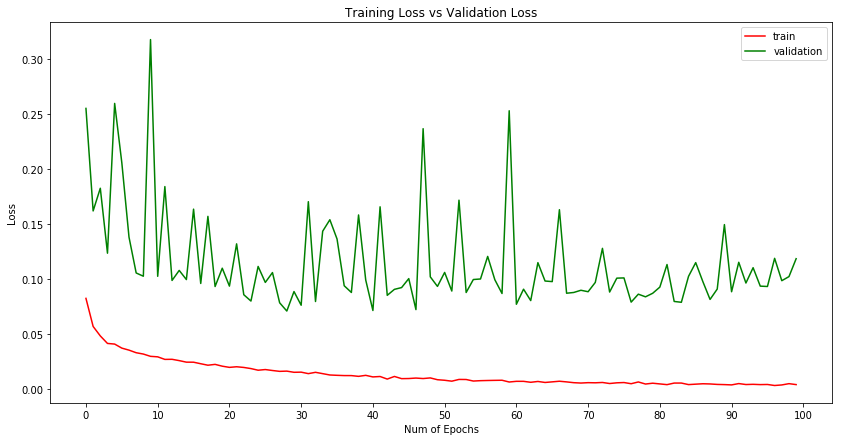

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(result.history['loss'],'r')
plt.plot(result.history['val_loss'],'g')
plt.xticks(np.arange(0, num_epochs+1, 10.0))
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
plt.show()

# Learning Rate

This learning rate looks healthy. The best weights were at epoch 29, and if you look closely you can see how validation loss converges to that point and then gets fairly erratic after. This indicates that the model begins to overfit after epoch 29. Below we look at the results for epoch 29 on validation and train.

In [8]:
model.load_weights('mammo-weights-transfer\weights-improvement-29-0.97.hdf5')
predict_and_report(validation_generator, model)
predict_and_report(train_generator, model)

Accuracy: 0.9748696064485538
Area Under the Receiver Operating Characteristic Curve: 0.9532472312447491
             precision    recall  f1-score   support

          0       0.99      0.98      0.99      7343
          1       0.89      0.92      0.91      1093

avg / total       0.98      0.97      0.98      8436

Accuracy: 0.9792109917715516
Area Under the Receiver Operating Characteristic Curve: 0.9795494684108464
             precision    recall  f1-score   support

          0       1.00      0.98      0.99     33909
          1       0.88      0.98      0.92      5102

avg / total       0.98      0.98      0.98     39011

